## Shampoo EoS Investigation
Full-batch CIFAR-10, MLP4 (170 hidden units), MSE loss.
Shampoo applied to inner weight matrices (h2, h3), Adam on all other parameters.
Investigates whether Shampoo exhibits Edge of Stability (sharpness approaching 2/lr).

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import src.seed as seed
import src.models as models
import src.functions as fn

import torch
torch.set_num_interop_threads(1)
torch.set_num_threads(1)

import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pio.renderers.default = "plotly_mimetype"
device = torch.device("cpu")
generator = seed.generator

In [2]:
class Shampoo(torch.optim.Optimizer):
    """Shampoo optimizer for 2D weight matrices.

    Keeps two small matrices per layer that accumulate gradient statistics
    across rows and columns of each weight matrix. Uses these to rescale
    the gradient before each step -- stretching in unexplored directions
    and shrinking in directions with large historical gradients.
    
    1D parameters (biases) fall back to plain SGD.
    """

    def __init__(self, params, lr=1e-2, momentum=0.9, weight_decay=0.0,
                 update_freq=100, epsilon=1e-6):
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay,
                        update_freq=update_freq, epsilon=epsilon)
        super().__init__(params, defaults)

    @staticmethod
    def _inv_quarter(M):
        """Computes M to the power of -1/4 via eigendecomposition."""
        eigvals, eigvecs = torch.linalg.eigh(M)
        inv_quarter = eigvals.clamp(min=1e-30).pow(-0.25)
        return eigvecs @ torch.diag(inv_quarter) @ eigvecs.T

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr          = group['lr']
            momentum    = group['momentum']
            wd          = group['weight_decay']
            update_freq = group['update_freq']
            eps         = group['epsilon']

            for p in group['params']:
                if p.grad is None:
                    continue

                G = p.grad.data
                if wd != 0:
                    G = G.add(p.data, alpha=wd)

                state = self.state[p]

                if p.ndim == 2:
                    m, n = p.shape

                    if len(state) == 0:
                        state['step'] = 0
                        state['L'] = eps * torch.eye(m, device=p.device, dtype=p.dtype)
                        state['R'] = eps * torch.eye(n, device=p.device, dtype=p.dtype)
                        state['L_inv_q'] = torch.eye(m, device=p.device, dtype=p.dtype)
                        state['R_inv_q'] = torch.eye(n, device=p.device, dtype=p.dtype)
                        if momentum > 0:
                            state['G_avg'] = torch.zeros_like(G)

                    state['step'] += 1

                    if momentum > 0:
                        state['G_avg'].mul_(momentum).add_(G, alpha=1.0 - momentum)
                        G_eff = state['G_avg']
                    else:
                        G_eff = G

                    state['L'].add_(G @ G.T)
                    state['R'].add_(G.T @ G)

                    if state['step'] % update_freq == 1 or update_freq == 1:
                        state['L_inv_q'] = Shampoo._inv_quarter(state['L'])
                        state['R_inv_q'] = Shampoo._inv_quarter(state['R'])

                    update = state['L_inv_q'] @ G_eff @ state['R_inv_q']
                    p.data.add_(update, alpha=-lr)

                else:
                    p.data.add_(G, alpha=-lr)

        return loss

In [3]:
X, y, X_test, y_test = fn.load_cifar_10()

/scratch/z2qin/conda/envs/inv-nn-opt-env/lib/python3.11/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning:

dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)



In [4]:
class MLP4(nn.Module):
    """4 hidden layer MLP for CIFAR-10 classification."""
    def __init__(self, input_size, hidden_layer_size, num_labels, activation):
        super().__init__()
        self.input_size         = input_size
        self.hidden_layers_size = hidden_layer_size
        self.num_labels         = num_labels
        self.activation         = activation

        self.h1  = nn.Linear(input_size,        hidden_layer_size)
        self.h2  = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.h3  = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.h4  = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.out = nn.Linear(hidden_layer_size, num_labels)

        self.param_list = list(self.parameters())

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation(self.h1(x))
        x = self.activation(self.h2(x))
        x = self.activation(self.h3(x))
        x = self.activation(self.h4(x))
        return self.out(x)


def max_shampoo_layer_sharpness(model, opt_shampoo, criterion, X, y,
                                generator, subsample_dim=1024, iters=30, tol=1e-4):
    """Returns the maximum sharpness across all Shampoo weight matrices.
    Sharpness is estimated via power iteration on the Hessian restricted
    to each 2D weight matrix. Uses a random subsample of training data
    for efficiency.
    """
    shampoo_ws = [
        p for g in opt_shampoo.param_groups
        for p in g['params'] if p.ndim == 2
    ]
    n   = X.shape[0]
    m   = min(subsample_dim, n)
    idx = torch.randperm(n, device=X.device, generator=generator)[:m]
    Xs, ys = X[idx], y[idx]

    outputs = model(Xs)
    loss    = criterion(outputs, ys)

    def _layer_sharpness(W):
        (gW,) = torch.autograd.grad(loss, W, create_graph=True, retain_graph=True)
        g_flat = gW.reshape(-1)

        def Hv(v):
            (hW,) = torch.autograd.grad(g_flat @ v, W, retain_graph=True)
            return hW.reshape(-1)

        v = torch.randn(g_flat.numel(), device=W.device, generator=generator)
        v = v / (v.norm() + 1e-12)
        eig_old = 0.0
        for _ in range(iters):
            w   = Hv(v)
            eig = (v @ w).item()
            v   = w / (w.norm() + 1e-12)
            if abs(eig - eig_old) / (abs(eig_old) + 1e-12) < tol:
                break
            eig_old = eig
        return (v @ Hv(v)).item()

    return max(_layer_sharpness(W) for W in shampoo_ws)

In [5]:
def train_shampoo_model(model, opt_shampoo, opt_adam, criterion, epochs, accuracy,
                        X, y, X_test, y_test, output_dir, generator):
    """Trains MLP4 with Shampoo on the inner layers and Adam on the rest.
    Records loss, accuracy, and sharpness every 50 epochs.
    Stops early if loss becomes NaN.
    """
    
    lr       = opt_shampoo.param_groups[0]['lr']
    momentum = opt_shampoo.param_groups[0].get('momentum', 0.0)
    print(f"Training {model.__class__.__name__} with "
          f"{opt_shampoo.__class__.__name__} and learning rate "
          f"{lr} for {epochs} epochs.")

    model.to(device)
    model.train()

    train_losses     = np.full(epochs, np.nan)
    train_accuracies = np.full(epochs, np.nan)
    test_accuracies  = np.full(epochs, np.nan)
    H_sharps         = np.full(epochs, np.nan)
    A_sharps         = np.full(epochs, np.nan)

    if isinstance(criterion, nn.MSELoss):
        y_loss = F.one_hot(y, num_classes=model.num_labels).float().to(device)
    else:
        y_loss = y.to(device)

    start     = time.time()
    train_acc = 0.0
    epoch     = 0
    loss      = torch.tensor(0.0)

    while train_acc < accuracy and epoch < epochs:
        opt_shampoo.zero_grad(set_to_none=True)
        opt_adam.zero_grad(set_to_none=True)

        outputs = model(X)
        loss    = criterion(outputs, y_loss)
        loss.backward()

        opt_shampoo.step()
        opt_adam.step()

        train_losses[epoch] = loss.item()

        if torch.isnan(loss):
            print(f"  Loss is NaN at epoch {epoch+1}, stopping early.")
            break

        if epoch % 50 == 0:
            H_sharps[epoch], _ = fn.get_hessian_metrics(
                model, opt_shampoo, criterion, X, y_loss, generator=generator
            )
            A_sharps[epoch] = max_shampoo_layer_sharpness(
                model, opt_shampoo, criterion, X, y_loss, generator=generator
            )

        with torch.no_grad():
            model.eval()
            train_preds = outputs.argmax(dim=1)
            test_preds  = model(X_test).argmax(dim=1)
            train_acc   = (train_preds == y).float().mean().item()
            test_acc    = (test_preds  == y_test).float().mean().item()
            train_accuracies[epoch] = train_acc
            test_accuracies[epoch]  = test_acc
        model.train()

        if (epoch + 1) % 100 == 0:
            print(f"  Epoch [{epoch+1}/{epochs}]  "
                  f"loss={loss.item():.4f}  "
                  f"time={round((time.time()-start)/60, 2)}m  "
                  f"train_acc={train_acc:.4f}  "
                  f"test_acc={test_acc:.4f}")
        epoch += 1

    metadata, output_data = fn.setup_output_files(output_dir)
    model_id = metadata.shape[0] + 1

    metadata.loc[metadata.shape[0]] = {
        'model_id':            model_id,
        'model_type':          model.__class__.__name__,
        'activation_function': model.activation.__name__,
        'optimizer':           opt_shampoo.__class__.__name__,
        'criterion':           criterion.__class__.__name__,
        'learning_rate':       lr,
        'momentum':            momentum,
        'num_epochs':          epochs,
        'time_minutes':        round((time.time() - start) / 60, 2),
    }

    output_data = pd.concat([output_data, pd.DataFrame({
        'model_id':       np.ones_like(train_losses) * model_id,
        'epoch':          np.arange(1, epochs + 1),
        'train_loss':     train_losses,
        'sharpness_H':    H_sharps.round(4),
        'sharpness_A':    A_sharps.round(4),
        'test_accuracy':  test_accuracies,
        'train_accuracy': train_accuracies,
    })], ignore_index=True)

    fn.save_output_files(metadata, output_data, output_dir)

## Sweep over 5 learning rates 
Trains one model per LR and saves results:

In [6]:
output_dir        = "eos/shampoo_ZJ"
input_size        = 32 * 32 * 3
hidden_layer_size = 170
num_labels        = 10
activation        = F.relu
criterion         = nn.MSELoss()

learning_rates = [1e-2, 3e-3, 1e-3, 3e-4, 1e-4]

for lr in learning_rates:
    model = MLP4(input_size, hidden_layer_size, num_labels, activation)

    all_params     = set(model.parameters())
    shampoo_params = list({model.h2.weight, model.h3.weight})
    adamw_params   = list(all_params - set(shampoo_params))

    opt_shampoo = Shampoo(
        shampoo_params,
        lr=lr,
        momentum=0.9,
        weight_decay=0,
        update_freq=100,
        epsilon=1e-6,
    )
    opt_adam = torch.optim.Adam(adamw_params, lr=lr)

    train_shampoo_model(
        model       = model,
        opt_shampoo = opt_shampoo,
        opt_adam    = opt_adam,
        criterion   = criterion,
        epochs      = 500,
        accuracy    = 1.1,
        X           = X,
        y           = y,
        X_test      = X_test,
        y_test      = y_test,
        output_dir  = output_dir,
        generator   = generator,
    )

Training MLP4 with Shampoo and learning rate 0.01 for 500 epochs.
  Loss is NaN at epoch 8, stopping early.
Training MLP4 with Shampoo and learning rate 0.003 for 500 epochs.


/tmp/ipykernel_827/1641005589.py:91: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



  Epoch [100/500]  loss=0.0345  time=0.42m  train_acc=0.8294  test_acc=0.3770
  Epoch [200/500]  loss=0.0031  time=0.87m  train_acc=0.9962  test_acc=0.3800
  Epoch [300/500]  loss=0.0101  time=1.3m  train_acc=0.9630  test_acc=0.3390
  Epoch [400/500]  loss=0.0024  time=1.72m  train_acc=0.9934  test_acc=0.3680
  Epoch [500/500]  loss=0.0009  time=2.15m  train_acc=0.9966  test_acc=0.3690
Training MLP4 with Shampoo and learning rate 0.001 for 500 epochs.
  Epoch [100/500]  loss=0.0221  time=0.45m  train_acc=0.9552  test_acc=0.4140
  Epoch [200/500]  loss=0.0062  time=0.89m  train_acc=0.9958  test_acc=0.3810
  Epoch [300/500]  loss=0.0024  time=1.34m  train_acc=0.9990  test_acc=0.3750
  Epoch [400/500]  loss=0.0013  time=1.78m  train_acc=0.9998  test_acc=0.3870
  Epoch [500/500]  loss=0.0008  time=2.22m  train_acc=1.0000  test_acc=0.3740
Training MLP4 with Shampoo and learning rate 0.0003 for 500 epochs.
  Epoch [100/500]  loss=0.0417  time=0.51m  train_acc=0.8216  test_acc=0.4420
  Epoch 

In [7]:
output_dir = "eos/shampoo_ZJ"
# fn.delete_model_data(range(20), output_dir=output_dir)

In [8]:
output_dir = "eos/shampoo_ZJ"
md, out = fn.load_output_files(output_dir)

In [37]:
def plot_all_training_combined(metadata, output):
    """All learning rates on the same axes for direct comparison.
    Top: training loss (left axis) and sharpness (right axis).
    Bottom: train and test accuracy.
    """
    model_ids = sorted(metadata['model_id'].unique())
    colors = ['royalblue', 'crimson', 'seagreen', 'darkorange', 'mediumpurple']

    fig = make_subplots(
        rows=2, cols=1,
        specs=[[{'secondary_y': True}],
               [{'secondary_y': False}]],
        shared_xaxes=True,
        vertical_spacing=0.1,
    )

    for i, model_id in enumerate(model_ids):
        meta  = metadata[metadata['model_id'] == model_id]
        o     = output[output['model_id'] == model_id]
        lr    = meta['learning_rate'].iloc[0]
        color = colors[i]

        xs             = o['epoch'].values
        losses         = o['train_loss'].values
        sharpness_H    = o['sharpness_H'].values
        sharpness_A    = o['sharpness_A'].values
        train_accuracy = o['train_accuracy'].values
        test_accuracy  = o['test_accuracy'].values
        eos_threshold  = 2.0 / lr
        n_valid        = int(np.sum(~np.isnan(losses)))

        # Loss
        fig.add_trace(go.Scatter(
            x=xs[:n_valid], y=losses[:n_valid],
            name=f'Loss lr={lr}',
            line=dict(width=2, color=color),
            legendgroup=f'{lr}',
        ), secondary_y=False, row=1, col=1)

        # Sharpness H (full Hessian)
        fig.add_trace(go.Scatter(
            x=xs[:n_valid], y=sharpness_H[:n_valid],
            name=f'Sharpness H lr={lr}',
            mode='markers+lines',
            marker=dict(size=6, color=color),
            line=dict(width=1, color=color, dash='dot'),
            connectgaps=False,
            legendgroup=f'{lr}',
            showlegend=False
        ), secondary_y=True, row=1, col=1)

        # Sharpness A (Shampoo layers)
        fig.add_trace(go.Scatter(
            x=xs[:n_valid], y=sharpness_A[:n_valid],
            name=f'Sharpness A lr={lr}',
            mode='markers+lines',
            marker=dict(size=6, color=color, symbol='diamond'),
            line=dict(width=1, color=color, dash='dash'),
            connectgaps=False,
            legendgroup=f'{lr}',
            showlegend=False
        ), secondary_y=True, row=1, col=1)

        # EoS threshold
        fig.add_hline(
            y=eos_threshold,
            line_dash='dash', line_color=color, line_width=1,
            annotation_text=f'2/lr={eos_threshold:.0f}',
            annotation_font_size=9,
            annotation_font_color=color,
            row=1, col=1, secondary_y=True
        )

        # Train accuracy
        fig.add_trace(go.Scatter(
            x=xs[:n_valid], y=train_accuracy[:n_valid],
            name=f'Train Acc lr={lr}',
            line=dict(width=2, color=color),
            legendgroup=f'{lr}',
            showlegend=False
        ), row=2, col=1)

        # Test accuracy
        fig.add_trace(go.Scatter(
            x=xs[:n_valid], y=test_accuracy[:n_valid],
            name=f'Test Acc lr={lr}',
            line=dict(width=2, color=color, dash='dot'),
            legendgroup=f'{lr}',
            showlegend=False
        ), row=2, col=1)

    fig.update_yaxes(title_text='Training Loss', secondary_y=False, row=1, col=1)
    fig.update_yaxes(title_text='Sharpness', secondary_y=True, type='log', row=1, col=1)
    fig.update_yaxes(title_text='Accuracy', range=[0, 1.05], row=2, col=1)
    fig.update_xaxes(title_text='Epoch', row=2, col=1)

    fig.update_layout(
        title='Shampoo: All Learning Rates Combined',
        height=800, width=1000,
        legend=dict(x=1.01, y=1),
        margin=dict(r=150)
    )
    fig.show()

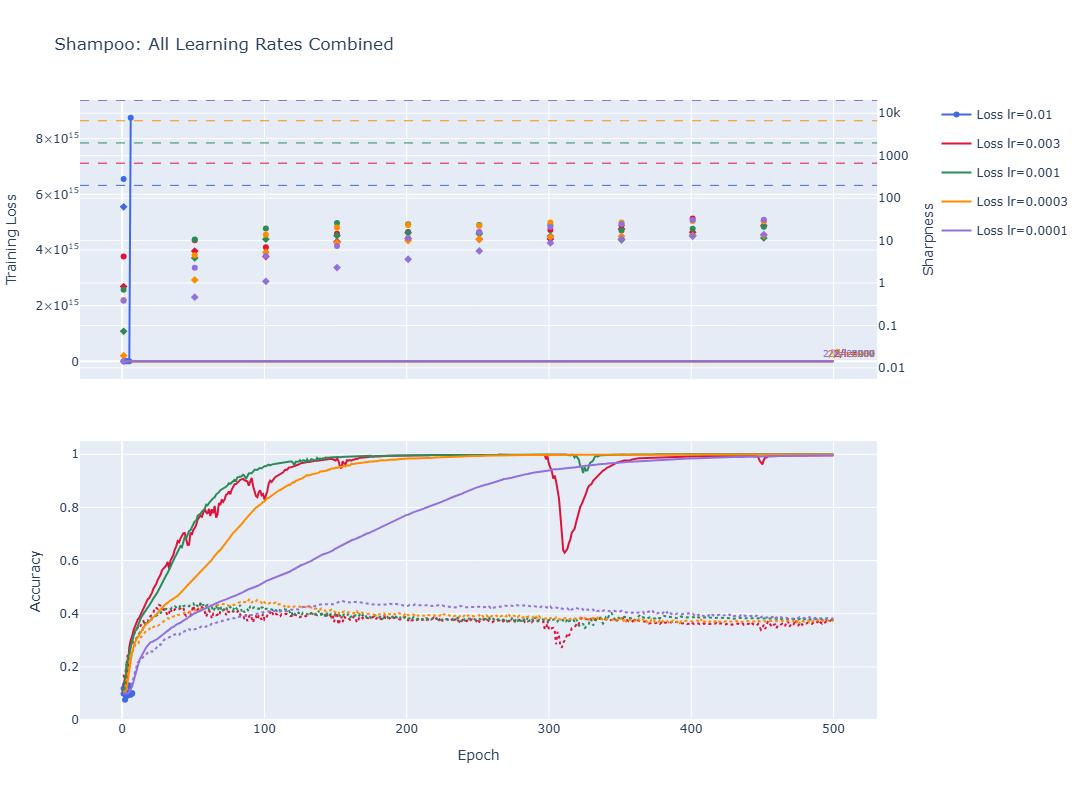

In [38]:
plot_all_training_combined(md, out)

In [19]:
def plot_output_data(metadata, output, model_id):
    meta = metadata[metadata['model_id'] == model_id]
    o    = output[output['model_id']    == model_id]

    num_epochs    = meta['num_epochs'].iloc[0]
    learning_rate = meta['learning_rate'].iloc[0]
    xs            = np.arange(num_epochs)

    losses         = o['train_loss'].values
    sharpness_H    = o['sharpness_H'].values
    sharpness_A    = o['sharpness_A'].values
    train_accuracy = o['train_accuracy'].values
    test_accuracy  = o['test_accuracy'].values
    eos_threshold  = 2.0 / learning_rate

    # Only plot epochs that actually ran
    n_valid = int(np.sum(~np.isnan(losses)))
    xs = xs[:n_valid]

    # Get actual sharpness range for readable axis
    valid_H = sharpness_H[~np.isnan(sharpness_H)]
    valid_A = sharpness_A[~np.isnan(sharpness_A)]
    if len(valid_H) > 0 and len(valid_A) > 0:
        sharp_max = max(np.nanmax(valid_H), np.nanmax(valid_A)) * 1.3
    else:
        sharp_max = eos_threshold

    fig = make_subplots(
        rows=2, cols=1,
        specs=[[{'secondary_y': True}],
               [{'secondary_y': False}]],
        shared_xaxes=True,
        vertical_spacing=0.12,
        subplot_titles=['Loss & Sharpness', 'Accuracy']
    )

    # Loss
    fig.add_trace(
        go.Scatter(x=xs, y=losses[:n_valid],
                   name='Training Loss',
                   line=dict(width=2, color='royalblue')),
        secondary_y=False, row=1, col=1
    )

    # Sharpness H (full Hessian)
    fig.add_trace(
        go.Scatter(x=xs, y=sharpness_H[:n_valid],
                   name='Sharpness H (full Hessian)',
                   mode='markers+lines',
                   marker=dict(size=8, color='crimson'),
                   line=dict(width=1, color='crimson', dash='dot'),
                   connectgaps=False),
        secondary_y=True, row=1, col=1
    )

    # Sharpness A (Shampoo layers)
    fig.add_trace(
        go.Scatter(x=xs, y=sharpness_A[:n_valid],
                   name='Sharpness A (Shampoo layers)',
                   mode='markers+lines',
                   marker=dict(size=8, color='seagreen'),
                   line=dict(width=1, color='seagreen', dash='dot'),
                   connectgaps=False),
        secondary_y=True, row=1, col=1
    )

    # EoS threshold line
    fig.add_hline(
        y=eos_threshold,
        line_dash='dash', line_color='black', line_width=1,
        annotation_text=f'2/lr = {eos_threshold:.1f}',
        annotation_position='top right',
        row=1, col=1, secondary_y=True
    )

    # Accuracy
    fig.add_trace(
        go.Scatter(x=xs, y=train_accuracy[:n_valid],
                   name='Train Accuracy',
                   line=dict(width=2, color='mediumpurple')),
        row=2, col=1
    )
    fig.add_trace(
        go.Scatter(x=xs, y=test_accuracy[:n_valid],
                   name='Test Accuracy',
                   line=dict(width=2, color='darkorange')),
        row=2, col=1
    )

    fig.update_yaxes(title_text='Training Loss',
                     secondary_y=False, row=1, col=1,
                     range=[0, max(0.11, np.nanmax(losses[:n_valid]) * 1.1)])
    fig.update_yaxes(title_text='Sharpness',
                     secondary_y=True, row=1, col=1,
                     range=[0, sharp_max])
    fig.update_yaxes(title_text='Accuracy',
                     range=[0, 1.05], row=2, col=1)
    fig.update_xaxes(title_text='Epoch', range=[0, n_valid])

    fig.update_layout(
        title_text=f'Shampoo Training: Loss and Sharpness over Epochs  |  LR = {learning_rate}',
        height=800, width=1000,
        legend=dict(x=1.08, y=1),
        margin=dict(r=200)
    )
    fig.show()

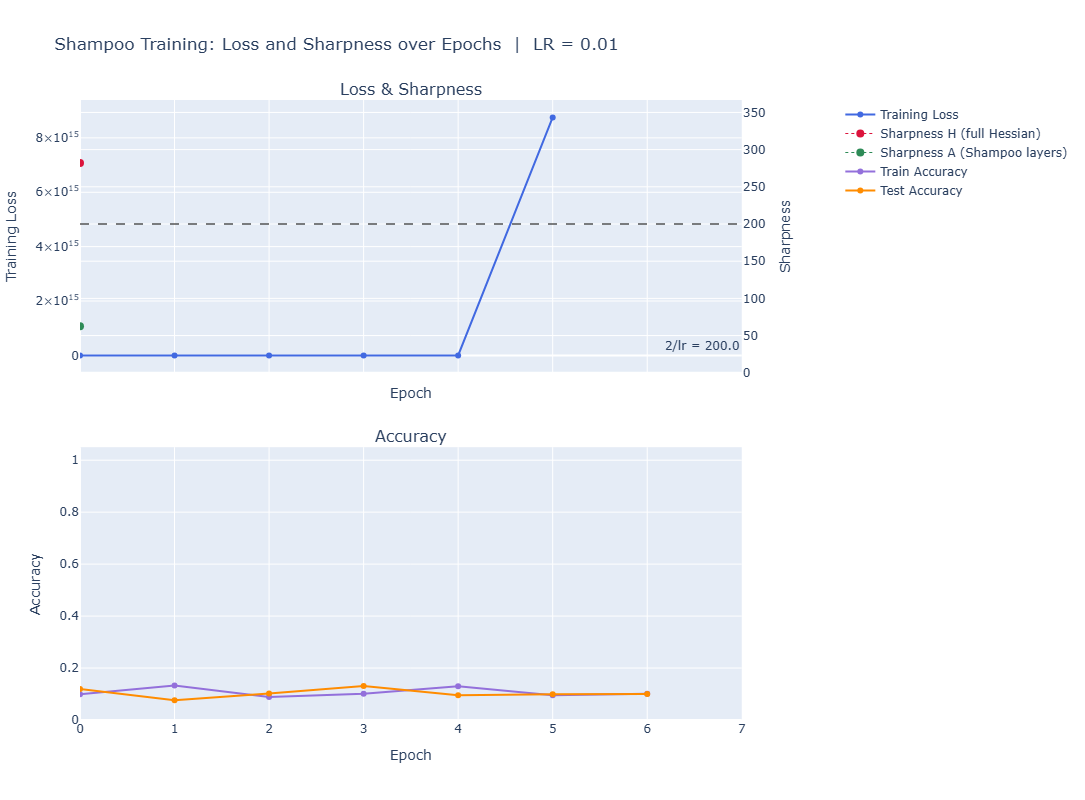

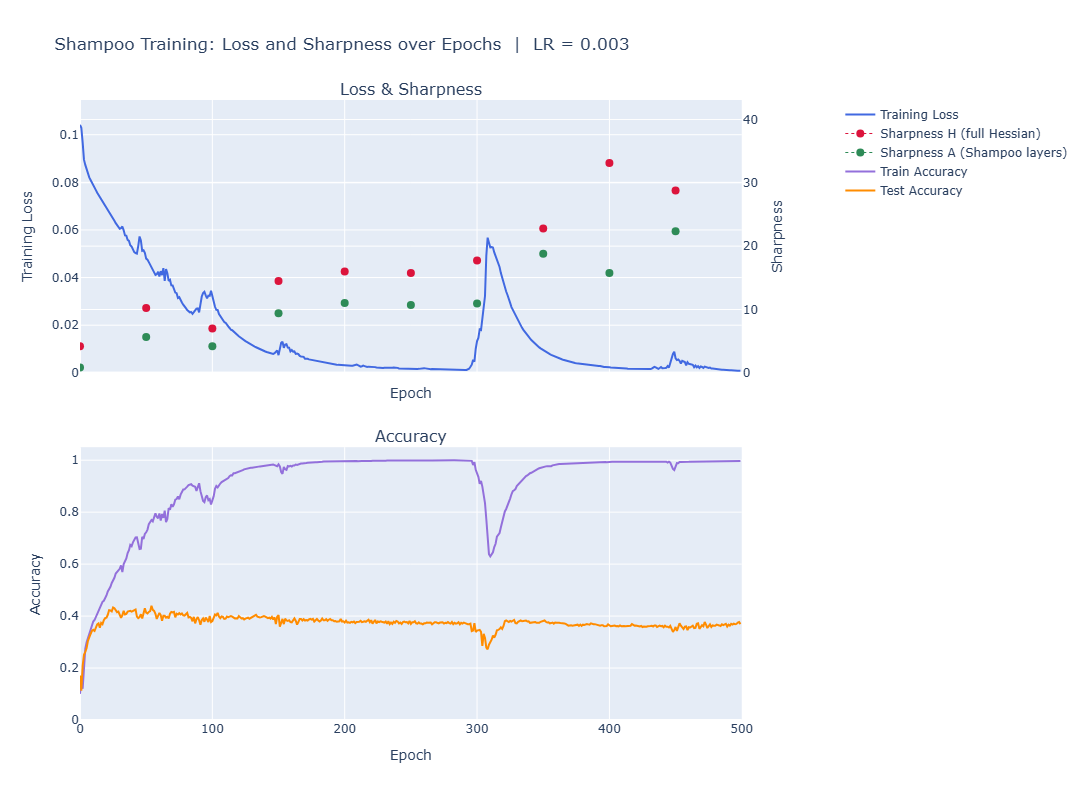

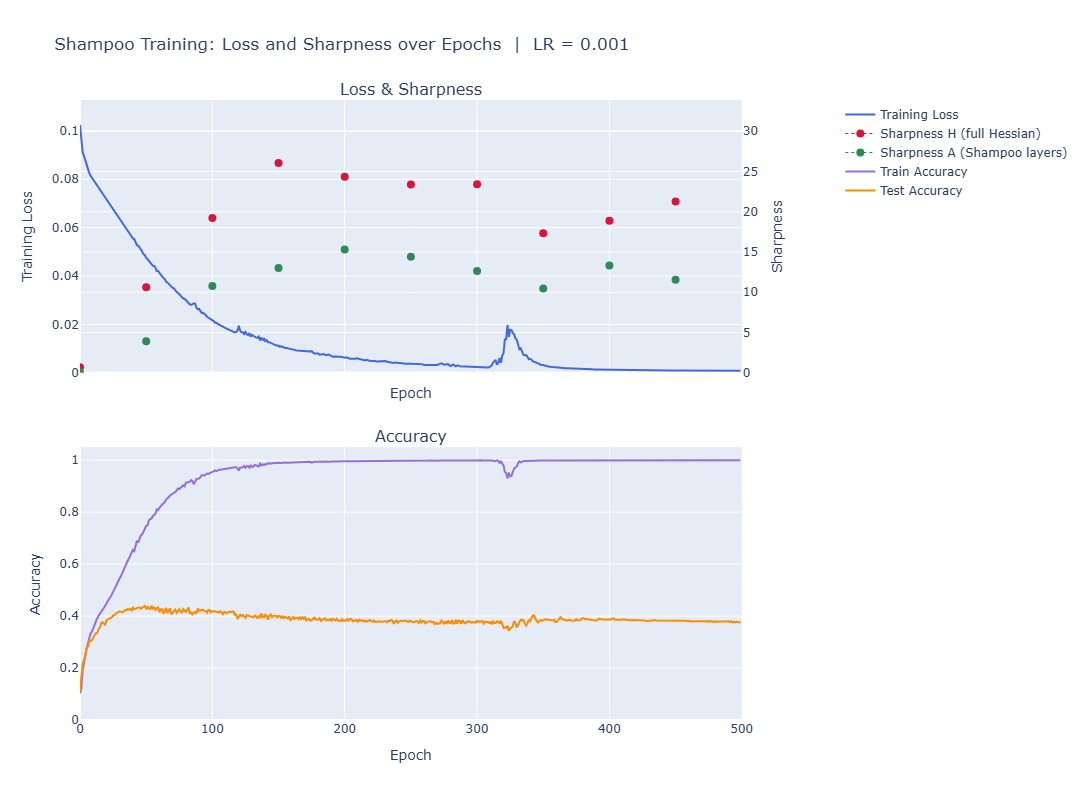

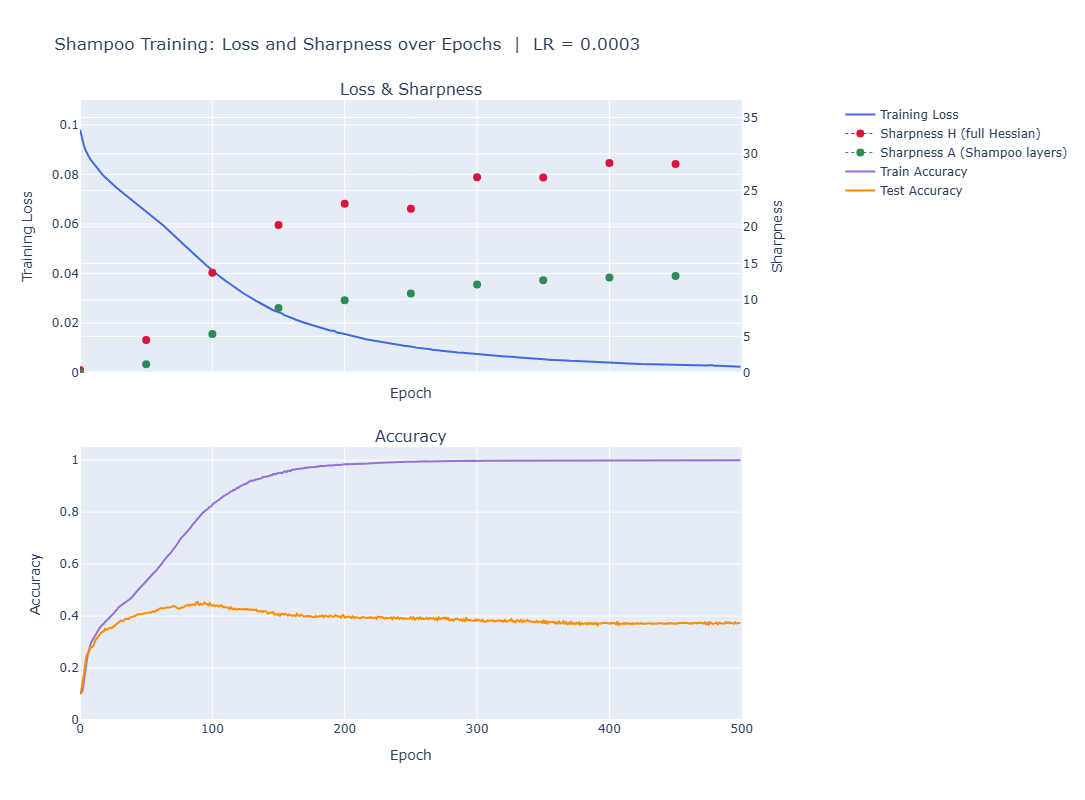

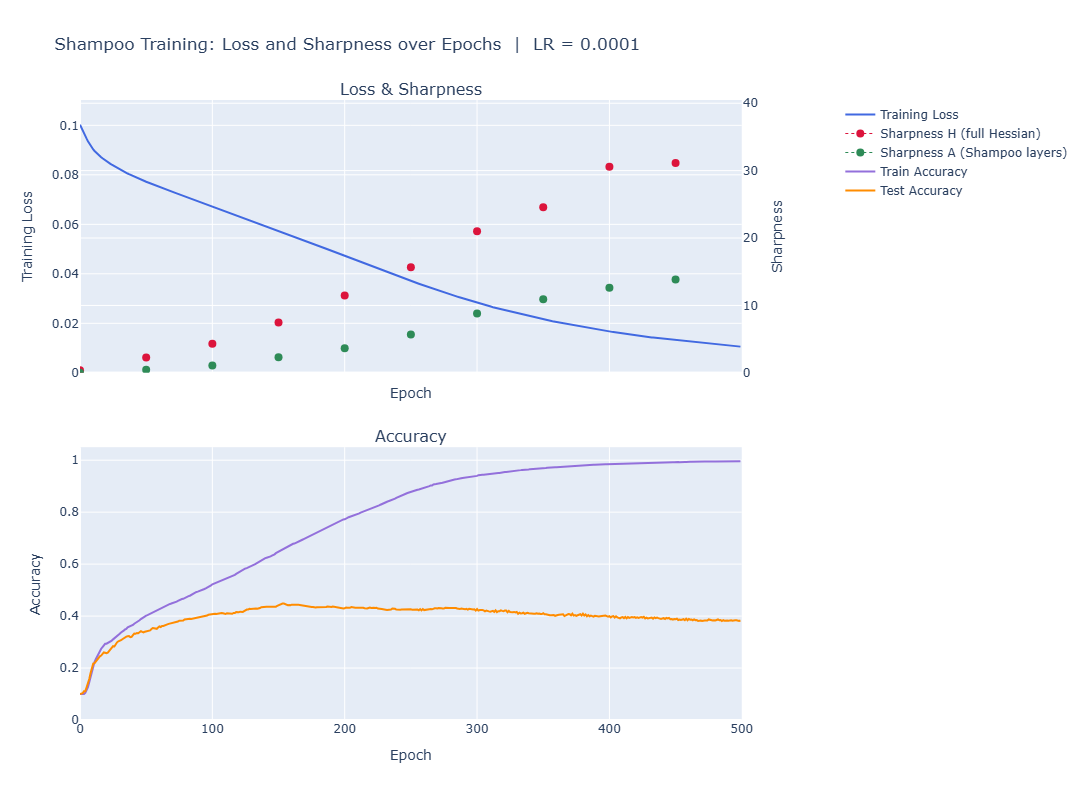

In [20]:
for model_id in sorted(md['model_id'].unique()):
    plot_output_data(md, out, model_id=model_id)

In [32]:
def plot_all_training(metadata, output):
    """Grid of training curves for all learning rates.
    Top row: loss and sharpness over epochs.
    Bottom row: train and test accuracy over epochs.
    """
    model_ids = sorted(metadata['model_id'].unique())
    n = len(model_ids)

    fig = make_subplots(
        rows=2, cols=n,
        specs=[[{'secondary_y': True}] * n,
               [{'secondary_y': False}] * n],
        shared_xaxes=False,
        vertical_spacing=0.12,
        horizontal_spacing=0.06,
        subplot_titles=[
            f'lr={metadata[metadata["model_id"]==mid]["learning_rate"].iloc[0]}'
            for mid in model_ids
        ] * 2
    )

    colors = ['royalblue', 'crimson', 'seagreen', 'darkorange', 'mediumpurple']

    for col, model_id in enumerate(model_ids, start=1):
        meta = metadata[metadata['model_id'] == model_id]
        o    = output[output['model_id'] == model_id]
        lr   = meta['learning_rate'].iloc[0]
        color = colors[col - 1]

        xs             = o['epoch'].values
        losses         = o['train_loss'].values
        sharpness_H    = o['sharpness_H'].values
        sharpness_A    = o['sharpness_A'].values
        train_accuracy = o['train_accuracy'].values
        test_accuracy  = o['test_accuracy'].values
        eos_threshold  = 2.0 / lr

        n_valid = int(np.sum(~np.isnan(losses)))

        # Get sharpness range for readable axis
        valid_H = sharpness_H[~np.isnan(sharpness_H)]
        valid_A = sharpness_A[~np.isnan(sharpness_A)]
        sharp_max = max(np.nanmax(valid_H), np.nanmax(valid_A)) * 1.3 if len(valid_H) > 0 else 100

        show_legend = (col == 1)

        # Loss
        fig.add_trace(go.Scatter(
            x=xs[:n_valid], y=losses[:n_valid],
            name='Train Loss', line=dict(width=2, color='royalblue'),
            showlegend=show_legend
        ), secondary_y=False, row=1, col=col)

        # Sharpness H
        fig.add_trace(go.Scatter(
            x=xs[:n_valid], y=sharpness_H[:n_valid],
            name='Sharpness H', mode='markers+lines',
            marker=dict(size=6, color='crimson'),
            line=dict(width=1, color='crimson', dash='dot'),
            connectgaps=False, showlegend=show_legend
        ), secondary_y=True, row=1, col=col)

        # Sharpness A
        fig.add_trace(go.Scatter(
            x=xs[:n_valid], y=sharpness_A[:n_valid],
            name='Sharpness A', mode='markers+lines',
            marker=dict(size=6, color='seagreen'),
            line=dict(width=1, color='seagreen', dash='dot'),
            connectgaps=False, showlegend=show_legend
        ), secondary_y=True, row=1, col=col)

        # EoS threshold
        fig.add_hline(
            y=eos_threshold,
            line_dash='dash', line_color='black', line_width=1,
            annotation_text=f'2/lr={eos_threshold:.0f}',
            annotation_font_size=9,
            row=1, col=col, secondary_y=True
        )

        # Train accuracy
        fig.add_trace(go.Scatter(
            x=xs[:n_valid], y=train_accuracy[:n_valid],
            name='Train Acc', line=dict(width=2, color='mediumpurple'),
            showlegend=show_legend
        ), row=2, col=col)

        # Test accuracy
        fig.add_trace(go.Scatter(
            x=xs[:n_valid], y=test_accuracy[:n_valid],
            name='Test Acc', line=dict(width=2, color='darkorange'),
            showlegend=show_legend
        ), row=2, col=col)

        # Axis labels only on leftmost column
        if col == 1:
            fig.update_yaxes(title_text='Loss', secondary_y=False, row=1, col=1)
            fig.update_yaxes(title_text='Sharpness', secondary_y=True, row=1, col=1)
            fig.update_yaxes(title_text='Accuracy', row=2, col=1)

        fig.update_yaxes(range=[0, sharp_max], secondary_y=True, row=1, col=col)
        fig.update_yaxes(range=[0, 1.05], row=2, col=col)

    fig.update_layout(
        title='Shampoo Training: All Learning Rates',
        height=600, width=300 * n,
        legend=dict(x=1.01, y=1),
        margin=dict(r=150)
    )
    fig.show()

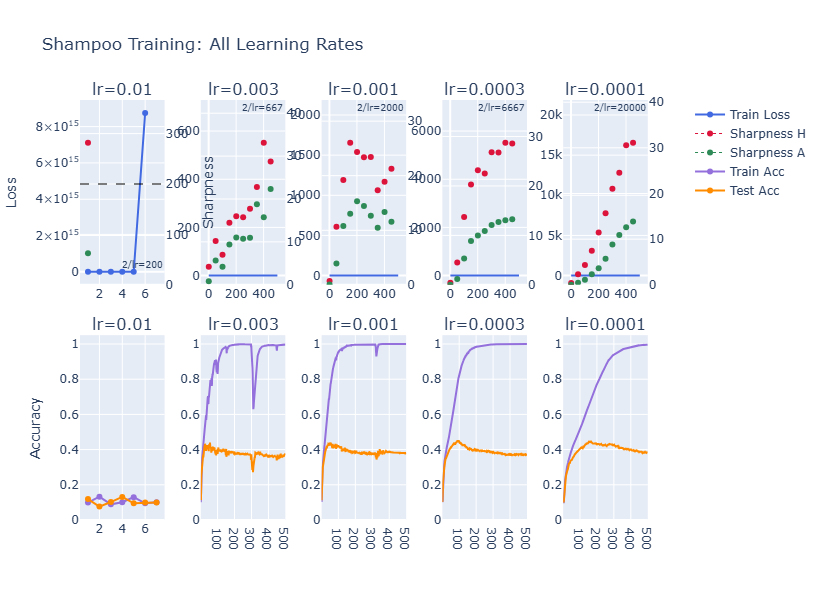

In [33]:
plot_all_training(md, out)

## Max Sharpness vs EoS Threshold

In [29]:
# Summary table of max sharpness vs EoS threshold
max_sharp = (
    out.groupby('model_id')
    .agg(max_sharpness_H=('sharpness_H', 'max'),
         max_sharpness_A=('sharpness_A', 'max'))
    .reset_index()
    .merge(md[['model_id', 'learning_rate']], on='model_id')
)
max_sharp['eos_threshold'] = 2.0 / max_sharp['learning_rate']
max_sharp['ratio'] = (max_sharp['max_sharpness_H'] / max_sharp['eos_threshold']).round(4)
max_sharp = max_sharp[['learning_rate', 'max_sharpness_H', 'max_sharpness_A', 'eos_threshold', 'ratio']]
max_sharp.columns = ['Learning Rate', 'Max Sharpness H', 'Max Sharpness A', 'EOS Threshold (2/lr)', 'Ratio H/Threshold']
print(max_sharp.to_string(index=False))

 Learning Rate  Max Sharpness H  Max Sharpness A  EOS Threshold (2/lr)  Ratio H/Threshold
        0.0100         282.0618          62.5003            200.000000             1.4103
        0.0030          33.1365          22.3601            666.666667             0.0497
        0.0010          26.0586          15.3006           2000.000000             0.0130
        0.0003          28.7664          13.2631           6666.666667             0.0043
        0.0001          31.1368          13.8572          20000.000000             0.0016


In [25]:
df_sharpness = (
    out.groupby('model_id')
    .apply(lambda x: x.dropna(subset=['sharpness_H']).iloc[-1])
    .reset_index(drop=True)
    .merge(md[['model_id', 'learning_rate']], on='model_id')
)[['learning_rate', 'sharpness_H', 'sharpness_A']].rename(
    columns={'learning_rate': 'lr'}
)
df_sharpness['eos_threshold'] = 2.0 / df_sharpness['lr']
print(df_sharpness)

       lr  sharpness_H  sharpness_A  eos_threshold
0  0.0100     282.0618      62.5003     200.000000
1  0.0030      28.7698      22.3601     666.666667
2  0.0010      21.2584      11.5697    2000.000000
3  0.0003      28.6145      13.2631    6666.666667
4  0.0001      31.1368      13.8572   20000.000000


/tmp/ipykernel_827/1250934697.py:3: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [26]:
def plot_sharpness_summary(metadata, output):
    """Plots max sharpness vs EoS threshold (2/lr) across all learning rates."""
    
    # Compute max sharpness per model from training data
    max_sharp = (
        output.groupby('model_id')
        .agg(max_sharpness_H=('sharpness_H', 'max'),
             max_sharpness_A=('sharpness_A', 'max'))
        .reset_index()
        .merge(metadata[['model_id', 'learning_rate']], on='model_id')
    )
    max_sharp['eos_threshold'] = 2.0 / max_sharp['learning_rate']
    df = max_sharp.dropna(subset=['max_sharpness_H'])

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df['learning_rate'], y=df['max_sharpness_H'],
        name='Max Sharpness H (full Hessian)', mode='markers+lines',
        marker=dict(size=10, color='crimson'),
        line=dict(width=2, color='crimson')
    ))
    fig.add_trace(go.Scatter(
        x=df['learning_rate'], y=df['max_sharpness_A'],
        name='Max Sharpness A (Shampoo layers)', mode='markers+lines',
        marker=dict(size=10, color='seagreen'),
        line=dict(width=2, color='seagreen')
    ))
    fig.add_trace(go.Scatter(
        x=df['learning_rate'], y=df['eos_threshold'],
        name='2/lr (EoS threshold)', mode='markers+lines',
        marker=dict(size=10, color='black', symbol='diamond'),
        line=dict(width=2, color='black', dash='dash')
    ))
    fig.update_layout(
        title='Shampoo: Max Sharpness vs EoS Threshold (2/LR) by Learning Rate',
        xaxis_title='Learning Rate',
        xaxis=dict(
            type='log',
            tickvals=[1e-4, 3e-4, 1e-3, 3e-3, 1e-2],
            ticktext=['0.0001', '0.0003', '0.001', '0.003', '0.01']
        ),
        yaxis_title='Sharpness',
        yaxis_type='log',
        height=500, width=900
    )
    fig.show()

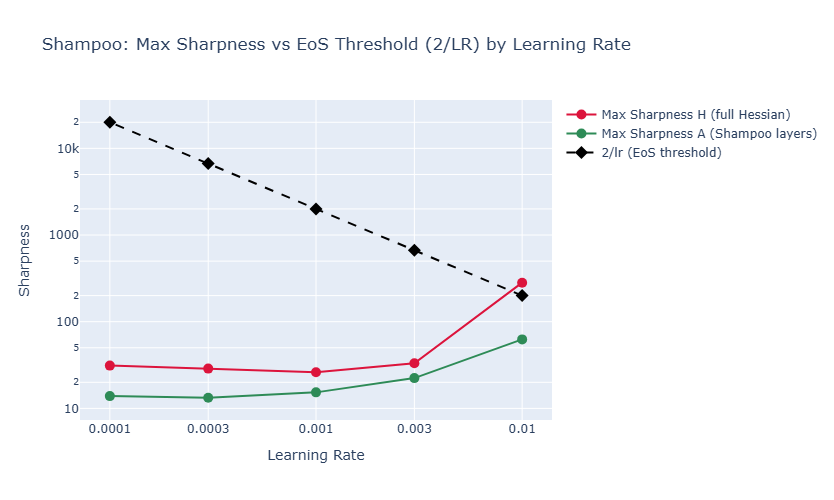

In [28]:
plot_sharpness_summary(md, out)